In [1]:
# Import all necessary libraries.
import os
import cv2
import numpy as np
import sys
import json
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# change this property
NOMEROFF_NET_DIR = os.path.abspath('../../../')

# specify the path to Mask_RCNN if you placed it outside Nomeroff-net project
MASK_RCNN_DIR = os.path.join(NOMEROFF_NET_DIR, 'Mask_RCNN')

MASK_RCNN_LOG_DIR = os.path.join(NOMEROFF_NET_DIR, 'logs')
OPTIONS_MODEL_PATH =  os.path.join(NOMEROFF_NET_DIR, "models/numberplate_options_2019_05_14.h5")

sys.path.append(NOMEROFF_NET_DIR)

In [2]:
# Import license plate recognition tools.
from NomeroffNet import  filters, RectDetector, TextDetector, OptionsDetector, Detector, textPostprocessing, textPostprocessingAsync

optionsDetector = OptionsDetector({
    "class_region": ["xx_unknown", "eu_ua_2015", "eu_ua_2004", "eu_ua_1995", "eu", "xx_transit", "ru", "kz", "kz-box"]
})
optionsDetector.load(OPTIONS_MODEL_PATH)

Using TensorFlow backend.
W0515 10:56:08.445056 140499392087680 deprecation_wrapper.py:119] From /var/www/nomeroff-net/NomeroffNet/Detector.py:12: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0515 10:56:08.445646 140499392087680 deprecation_wrapper.py:119] From /var/www/nomeroff-net/NomeroffNet/Detector.py:14: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0515 10:56:09.217039 140499392087680 deprecation_wrapper.py:119] From /usr/local/lib64/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0515 10:56:09.219424 140499392087680 deprecation_wrapper.py:119] From /usr/local/lib64/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0515 10:56:09.226511 140499392087680 deprecation_wrapper.py:119] From /usr/local/lib64/python3.7

In [11]:
def optionChecker(datasetDir, imgFormat="png", partSize=100):
    ann = "ann"
    img = "img"
    annDir = os.path.join(datasetDir, ann)
    imgDir = os.path.join(datasetDir, img)
    
    imgFnames        = []
    predictedRegions = []
    nottedRegions    = []
    nottedStates     = []
    zones            = []
    i = 0
    counter = Counter()
    for dirName, subdirList, fileList in os.walk(annDir):
        for fname in fileList:
            ann_path = os.path.join(annDir, fname)
            
            i += 1
            with open(ann_path) as jsonR:
                data = json.load(jsonR)
            img_name = data["name"]
            
            img_path = os.path.join(imgDir, "{}.{}".format(img_name, imgFormat))
            zones.append(cv2.cvtColor(mpimg.imread(img_path), cv2.COLOR_RGB2BGR))
            
            imgFnames.append(img_path)
            nottedRegions.append(data["region_id"])
            nottedStates.append(data["state_id"])
            if i >= partSize:
                # find standart
                regionIds, stateIds = optionsDetector.predict(zones)
                for regionId, stateId, zone, nottedRegion, nottedState, imgFname in zip(regionIds, stateIds, zones, nottedRegions, nottedStates, imgFnames):
                    if int(regionId) != int(nottedRegion):
                        print("REGION NOT CORRECT IN {}".format(imgFname))
                        print("PREDICTED: {}".format(regionId))
                        print("ANNOTATED: {}".format(nottedRegion))
                        plt.imshow(cv2.cvtColor(zone, cv2.COLOR_RGB2BGR))
                        plt.show()
                        counter["BAD"] += 1
                    else:
                        counter["GOOD"] += 1
                    if int(stateId) != int(nottedState):
                        print("STATE NOT CORRECT IN {}".format(imgFname))
                        print("PREDICTED: {}".format(stateId))
                        print("ANNOTATED: {}".format(nottedState))
                        plt.imshow(cv2.cvtColor(zone, cv2.COLOR_RGB2BGR))
                        plt.show()
                        counter["BAD"] += 1
                    else:
                        counter["GOOD"] += 1
                    
                imgFnames        = []
                predictedRegions = []
                nottedRegions    = []
                nottedStates     = []
                zones            = []
    print(counter)

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260251722.png
PREDICTED: 2
ANNOTATED: 0


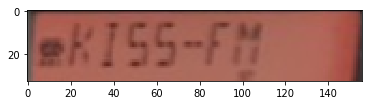

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260884364.png
PREDICTED: 4
ANNOTATED: 0


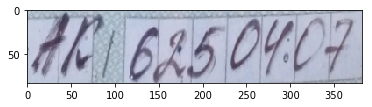

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260884364.png
PREDICTED: 2
ANNOTATED: 0


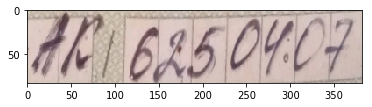

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/Y476TY57_1.png
PREDICTED: 4
ANNOTATED: 6


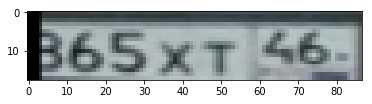

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/option_zero248731657-0.png
PREDICTED: 0
ANNOTATED: 1


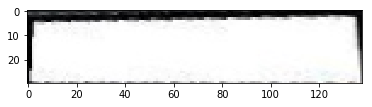

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260652076.png
PREDICTED: 2
ANNOTATED: 1


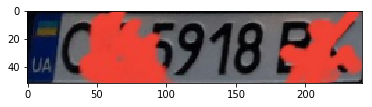

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/261064008.png
PREDICTED: 4
ANNOTATED: 0


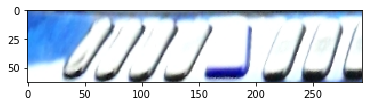

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/261064008.png
PREDICTED: 2
ANNOTATED: 0


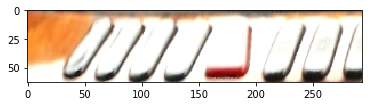

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260071879.png
PREDICTED: 1
ANNOTATED: 2


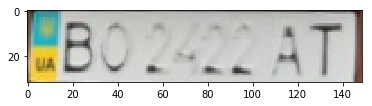

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/option_zero107860457-0.png
PREDICTED: 1
ANNOTATED: 2


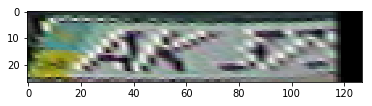

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/option_zero246943685-0.png
PREDICTED: 0
ANNOTATED: 1


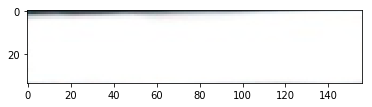

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260555638.png
PREDICTED: 0
ANNOTATED: 4


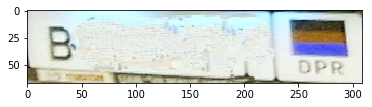

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260555638.png
PREDICTED: 0
ANNOTATED: 1


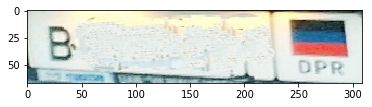

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/option_zero139453296-0.png
PREDICTED: 0
ANNOTATED: 2


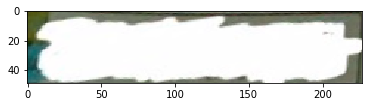

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260555635.png
PREDICTED: 0
ANNOTATED: 4


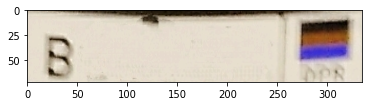

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260743739.png
PREDICTED: 2
ANNOTATED: 0


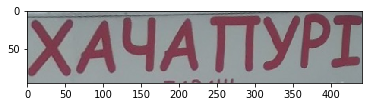

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260039000.png
PREDICTED: 1
ANNOTATED: 4


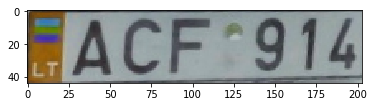

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/261096080.png
PREDICTED: 2
ANNOTATED: 0


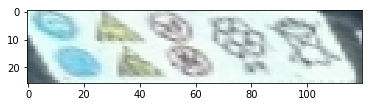

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260576610.png
PREDICTED: 2
ANNOTATED: 3


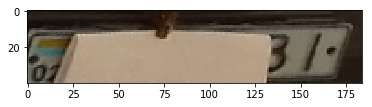

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/820AN15.png
PREDICTED: 6
ANNOTATED: 7


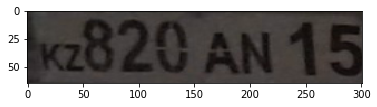

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260580205.png
PREDICTED: 0
ANNOTATED: 4


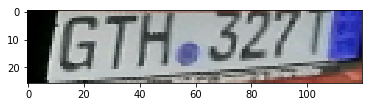

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/259936481.png
PREDICTED: 8
ANNOTATED: 0


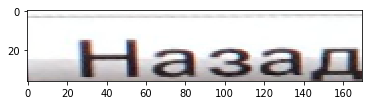

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/259971758.png
PREDICTED: 1
ANNOTATED: 4


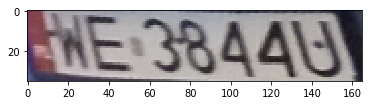

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260617418.png
PREDICTED: 7
ANNOTATED: 3


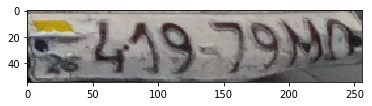

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/261165082.png
PREDICTED: 8
ANNOTATED: 3


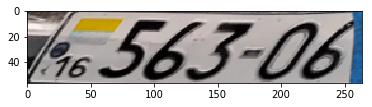

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/261270275.png
PREDICTED: 2
ANNOTATED: 0


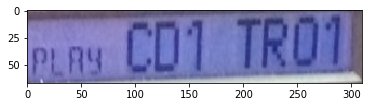

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260264549.png
PREDICTED: 0
ANNOTATED: 4


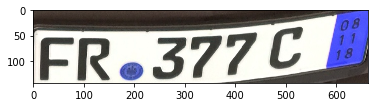

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260264549.png
PREDICTED: 0
ANNOTATED: 2


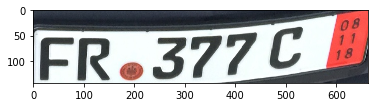

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260233350.png
PREDICTED: 8
ANNOTATED: 0


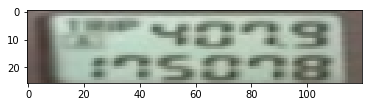

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260040771.png
PREDICTED: 2
ANNOTATED: 1


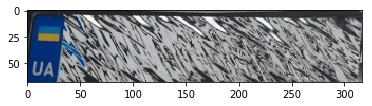

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260261557.png
PREDICTED: 4
ANNOTATED: 1


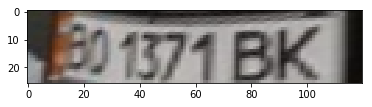

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260252661.png
PREDICTED: 3
ANNOTATED: 4


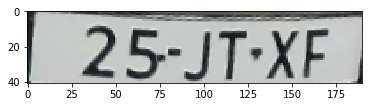

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260233314.png
PREDICTED: 2
ANNOTATED: 4


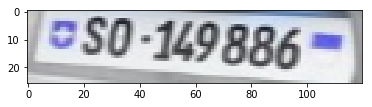

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260233314.png
PREDICTED: 0
ANNOTATED: 2


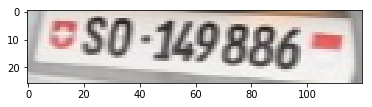

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260246552.png
PREDICTED: 0
ANNOTATED: 1


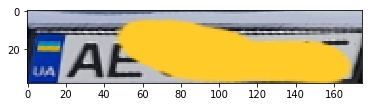

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260648062.png
PREDICTED: 2
ANNOTATED: 1


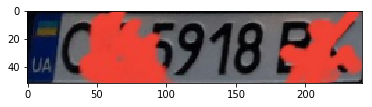

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/261276107.png
PREDICTED: 3
ANNOTATED: 0


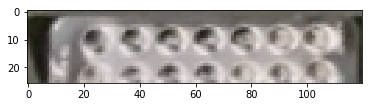

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/261276107.png
PREDICTED: 2
ANNOTATED: 0


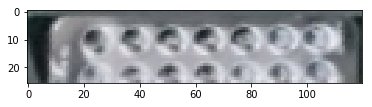

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260264189.png
PREDICTED: 0
ANNOTATED: 1


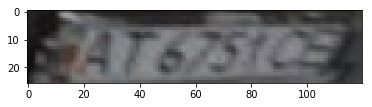

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260911228.png
PREDICTED: 0
ANNOTATED: 4


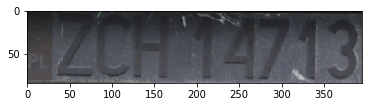

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260911228.png
PREDICTED: 0
ANNOTATED: 2


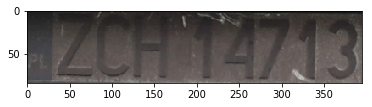

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/1481DB-0.png
PREDICTED: 0
ANNOTATED: 8


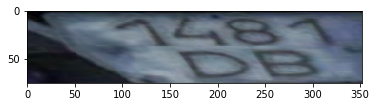

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/1481DB-0.png
PREDICTED: 0
ANNOTATED: 2


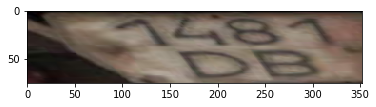

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/261091566.png
PREDICTED: 0
ANNOTATED: 2


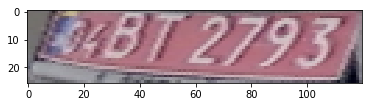

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260848097.png
PREDICTED: 4
ANNOTATED: 3


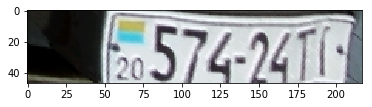

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260870414.png
PREDICTED: 8
ANNOTATED: 0


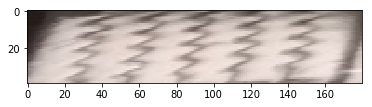

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260614612.png
PREDICTED: 0
ANNOTATED: 5


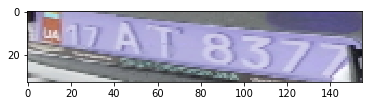

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/260614612.png
PREDICTED: 0
ANNOTATED: 2


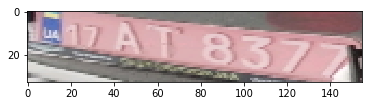

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/261086265.png
PREDICTED: 4
ANNOTATED: 0


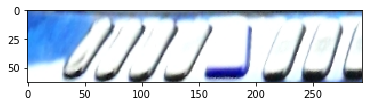

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/val/img/261086265.png
PREDICTED: 2
ANNOTATED: 0


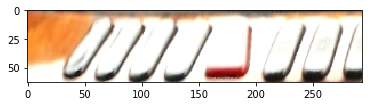

Counter({'GOOD': 15090, 'BAD': 50})


In [7]:
valDir = os.path.join(NOMEROFF_NET_DIR, "datasets/options/val")
optionChecker(valDir)

In [16]:
(15090- 50)/15090

0.9966865473823724

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/261435773.png
PREDICTED: 3
ANNOTATED: 4


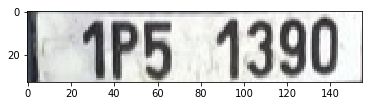

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260594936.png
PREDICTED: 0
ANNOTATED: 4


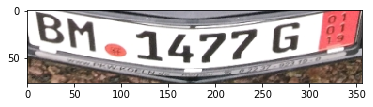

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/261083219.png
PREDICTED: 5
ANNOTATED: 1


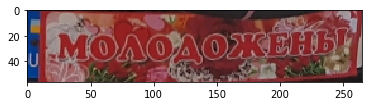

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/261083219.png
PREDICTED: 2
ANNOTATED: 0


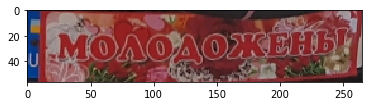

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/option_zero141138671-0.png
PREDICTED: 0
ANNOTATED: 2


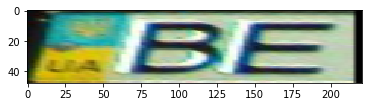

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260224248.png
PREDICTED: 4
ANNOTATED: 0


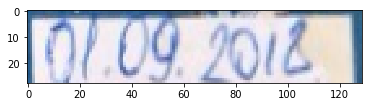

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260229542.png
PREDICTED: 1
ANNOTATED: 2


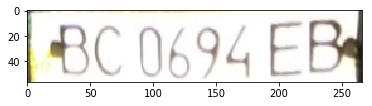

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260263165.png
PREDICTED: 2
ANNOTATED: 1


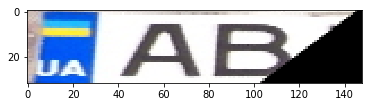

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260033319.png
PREDICTED: 2
ANNOTATED: 0


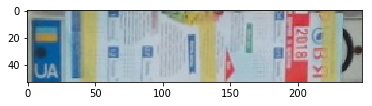

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260247692.png
PREDICTED: 0
ANNOTATED: 4


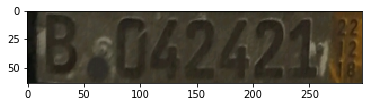

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260597490.png
PREDICTED: 1
ANNOTATED: 2


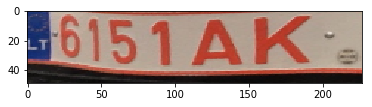

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/option_zero248062547-0.png
PREDICTED: 0
ANNOTATED: 1


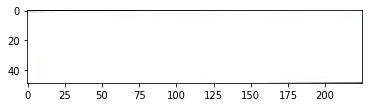

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260233327.png
PREDICTED: 2
ANNOTATED: 4


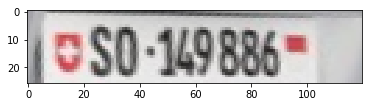

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260228944.png
PREDICTED: 6
ANNOTATED: 4


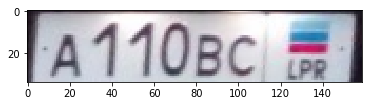

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260061951.png
PREDICTED: 1
ANNOTATED: 4


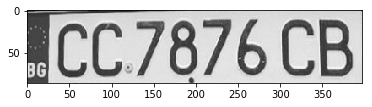

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/259997248.png
PREDICTED: 7
ANNOTATED: 4


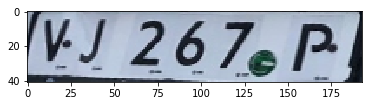

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260699361.png
PREDICTED: 2
ANNOTATED: 1


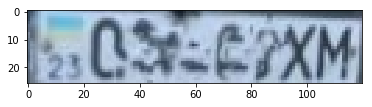

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/261067207.png
PREDICTED: 2
ANNOTATED: 0


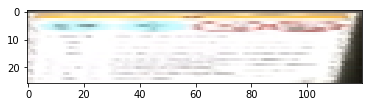

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260022059.png
PREDICTED: 0
ANNOTATED: 1


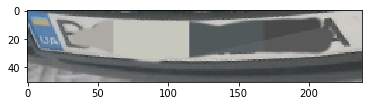

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260022059.png
PREDICTED: 0
ANNOTATED: 1


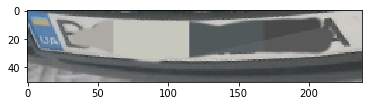

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260224173.png
PREDICTED: 1
ANNOTATED: 4


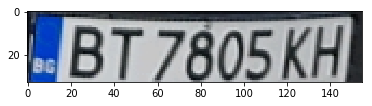

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260682656.png
PREDICTED: 2
ANNOTATED: 0


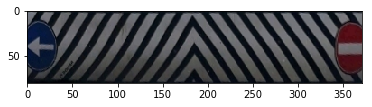

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/option_zero200396644-0.png
PREDICTED: 0
ANNOTATED: 2


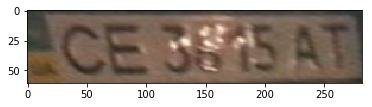

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260595639.png
PREDICTED: 0
ANNOTATED: 2


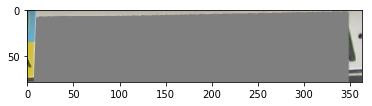

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260595639.png
PREDICTED: 0
ANNOTATED: 1


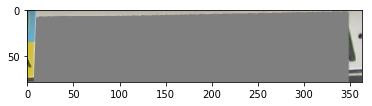

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/option_zero249263071-0.png
PREDICTED: 8
ANNOTATED: 0


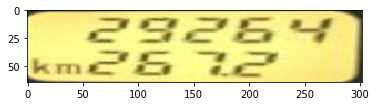

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/option_zero249263071-0.png
PREDICTED: 2
ANNOTATED: 0


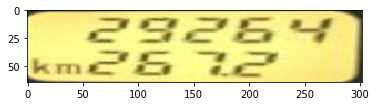

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260227758.png
PREDICTED: 6
ANNOTATED: 0


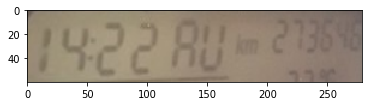

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260645211.png
PREDICTED: 0
ANNOTATED: 2


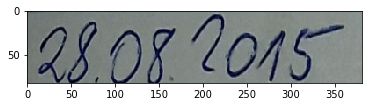

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/option_zero247860047-0.png
PREDICTED: 0
ANNOTATED: 4


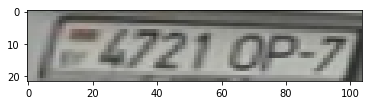

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/261270697.png
PREDICTED: 2
ANNOTATED: 0


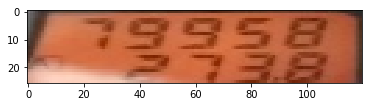

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/12551140.jpg-0.png
PREDICTED: 3
ANNOTATED: 7


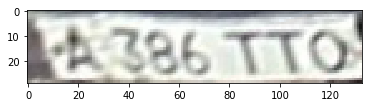

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260227958.png
PREDICTED: 0
ANNOTATED: 1


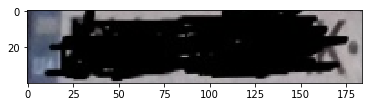

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/option_zero245400396-0.png
PREDICTED: 7
ANNOTATED: 4


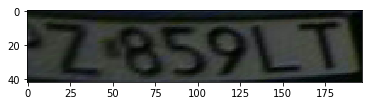

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/259975925.png
PREDICTED: 4
ANNOTATED: 0


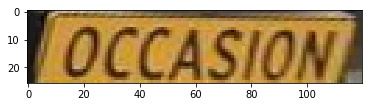

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/259975925.png
PREDICTED: 2
ANNOTATED: 0


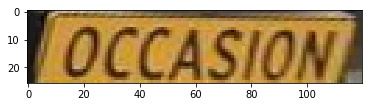

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260233308.png
PREDICTED: 0
ANNOTATED: 4


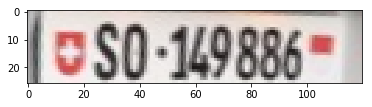

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260233308.png
PREDICTED: 0
ANNOTATED: 2


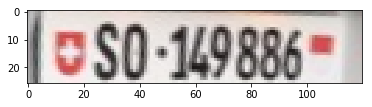

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260098110.png
PREDICTED: 2
ANNOTATED: 0


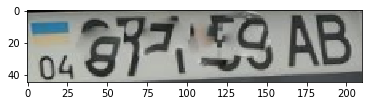

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260554425.png
PREDICTED: 8
ANNOTATED: 0


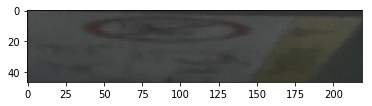

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260554425.png
PREDICTED: 2
ANNOTATED: 0


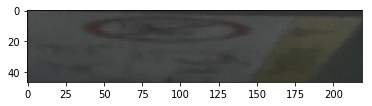

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260256606.png
PREDICTED: 1
ANNOTATED: 0


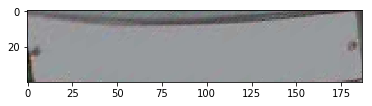

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260245693.png
PREDICTED: 1
ANNOTATED: 0


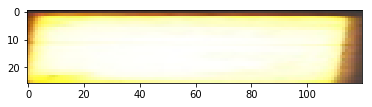

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260030307.png
PREDICTED: 1
ANNOTATED: 0


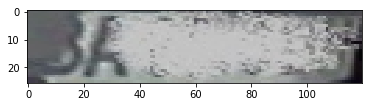

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/option_zero248062559-0.png
PREDICTED: 0
ANNOTATED: 1


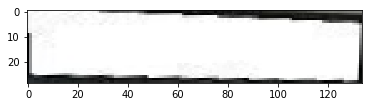

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260028674.png
PREDICTED: 2
ANNOTATED: 1


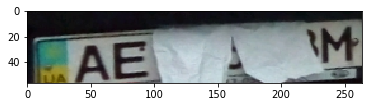

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260003420.png
PREDICTED: 0
ANNOTATED: 4


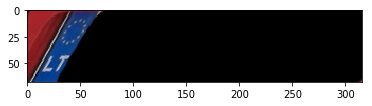

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260003420.png
PREDICTED: 0
ANNOTATED: 1


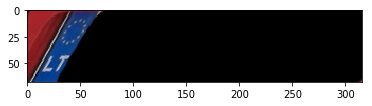

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260267062.png
PREDICTED: 1
ANNOTATED: 0


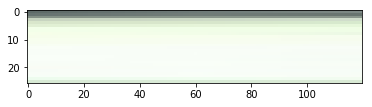

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260051172.png
PREDICTED: 2
ANNOTATED: 1


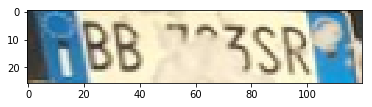

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260264268.png
PREDICTED: 7
ANNOTATED: 4


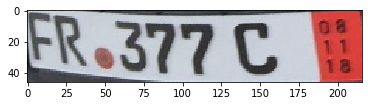

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/260655732.png
PREDICTED: 1
ANNOTATED: 2


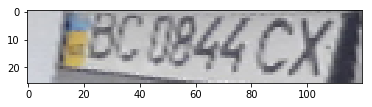

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/test/img/option_zero245144080-0.png
PREDICTED: 4
ANNOTATED: 2


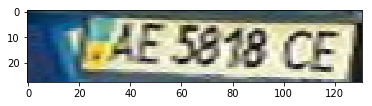

Counter({'GOOD': 12593, 'BAD': 53})


In [13]:
valDir = os.path.join(NOMEROFF_NET_DIR, "datasets/options/test")
optionChecker(valDir)

In [17]:
(12593-53)/12593

0.995791312634003

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/option_zero246983771-0.png
PREDICTED: 0
ANNOTATED: 2


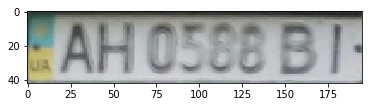

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/option_zero248062557-0.png
PREDICTED: 0
ANNOTATED: 1


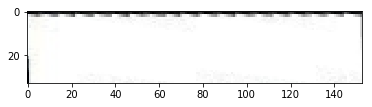

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/option_zero248731655-0.png
PREDICTED: 0
ANNOTATED: 1


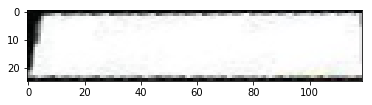

REGION NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/option_zero195228920-0.png
PREDICTED: 1
ANNOTATED: 2


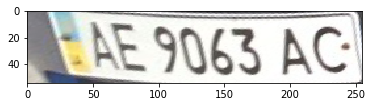

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/option_zero195228920-0.png
PREDICTED: 0
ANNOTATED: 2


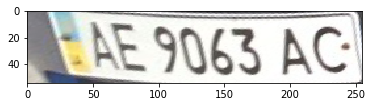

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/option_zero247023527-0.png
PREDICTED: 0
ANNOTATED: 2


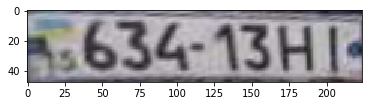

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/option_zero119914953-0.png
PREDICTED: 0
ANNOTATED: 1


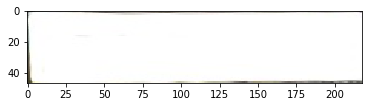

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/option_zero245389919-0.png
PREDICTED: 0
ANNOTATED: 2


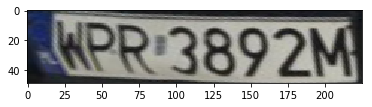

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/option_zero246944759-0.png
PREDICTED: 0
ANNOTATED: 1


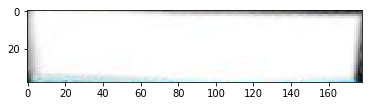

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/260237349.png
PREDICTED: 0
ANNOTATED: 2


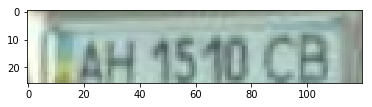

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/option_zero246943645-0.png
PREDICTED: 0
ANNOTATED: 1


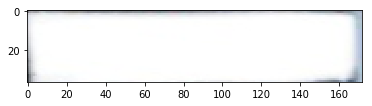

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/option_zero246944839-0.png
PREDICTED: 0
ANNOTATED: 1


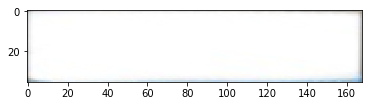

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/option_zero248257935-0.png
PREDICTED: 0
ANNOTATED: 2


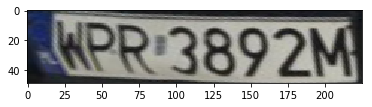

STATE NOT CORRECT IN /var/www/nomeroff-net/datasets/options/train/img/260102946.png
PREDICTED: 1
ANNOTATED: 0


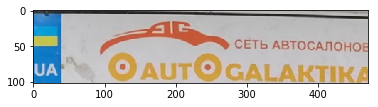

Counter({'GOOD': 58642, 'BAD': 14})


In [18]:
valDir = os.path.join(NOMEROFF_NET_DIR, "datasets/options/train")
optionChecker(valDir)

In [19]:
(58642-14)/58642

0.9997612632584155